# Linear Regression and Minimization - Workshop 

### Recap

In the introduction session, we discussed how to find the best-fit line to data. In this model, we found that the least-squares solution is mathematically identical to minimizing $\chi^2$:

$$
\chi^2 = \sum_{i=1}^N \frac{\left[ y_i - f(x_i) \right]^2}{\sigma^2_{y,i}}
$$


### In this session...

we are going to extend beyond linear models, to a model of arbitrary complexity. But first, let's look at the equation above. 

First, we have the summation: $\sum_{i=1}^N$. The fact that we are summing over indices implies we have a discreet number of data points. These data are represented by $x_i$ and $y_i$, as well as their uncertainties $\sigma_{y,i}$. 

$f(x_i)$ in the equation above is where our model comes in. There is no requirement that $f$ be a linear function, only that it is a _generative model_. A generative model means that our model can "produce" mock data. In our case, that means that, for a give input $x_i$, our model provides exactly one model output $y_i$. The $\chi^2$ equation above allows us statistically compare the model output with the observations.

So, to use $\chi^2$ minimization techniques, all we need to do is write down a function, $f(x)$ that gives us an output to compare with the observed data points. 


### The problem: fitting a spectral line

Spectroscopy, in which we break up the light from an object (star, galaxy, planet, etc.) into its separate wavelengths, is currently, and has been over the past century, a driving technique in astronomy. It allows us to measure the elemental abundances of stars and the star formation histories of galaxies, to give just two examples. It also allows us to measure the properties of a white dwarf, specifically the temperature and surface gravity. 

Quantum mechanics predicts that a spectral feature ought to be Gaussian in shape. However, in real stars, lines are typically broadened due to two effects that essentially cause a Doppler shift in the line: rotation and pressure (temperature). Rotation is clear: one side of the star is moving toward the observer (blue shift) while the other side is moving away (red shift). Because the gas is pressurized, random motions of the individual molecules with be either toward or away from the observer - the net effect is a broadened line. Pressure broadening produces a Cauchy distribution in the feature (for stars, these are typically absorption features):

$$
P(x) = -\frac{1}{\pi \gamma \left[ 1 + \left( \frac{x-x_0}{\gamma} \right)^2 \right]}
$$

By measuring the broadening ($\gamma$), one can determine the temperature at the photosphere of a white dwarf. The question is, how do we find the broadening of the line?

### First, let's load up our libraries and data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Load up the data

We will load up the spectra of the white dwarf. You can look at the data file if you'd like. It only has two columns: wavelength and flux. We will use `np.genfromtxt` to load the data into a numpy array. This spectra is taken with the UVES instrument on VLT, which has an extremely high resolution ($\Delta \lambda =0.1 Å$).

In [2]:
spec = np.genfromtxt("data/HS_2220+2146A_1.dat", dtype=[('wavelength','f8'),('flux','f8')])

### Now, let's plot the spectra

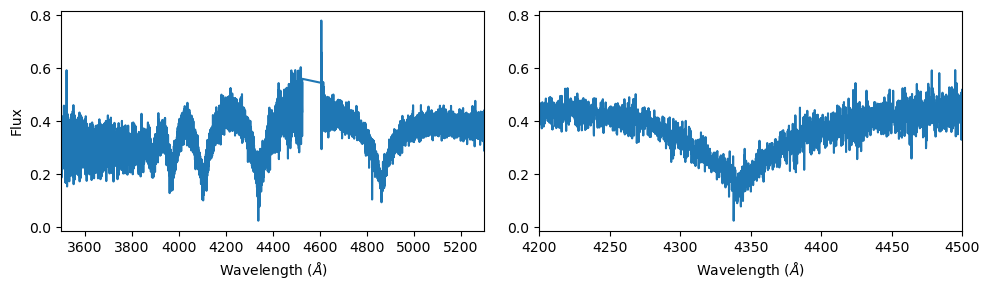

In [3]:
# Create a two-panel plot
fig, ax = plt.subplots(1, 2, figsize=(10,3))

# Plot in the left panel
ax[0].plot(spec['wavelength'], spec['flux'])

# Plot in the right panel
ax[1].plot(spec['wavelength'], spec['flux'])


# Set the range of the plot
ax[0].set_xlim(3500, 5300)
ax[1].set_xlim(4200, 4500)

# Add axis labels
for a in ax: a.set_xlabel(r'Wavelength ($\AA$)')
ax[0].set_ylabel('Flux')
    
# Show the plot
plt.tight_layout()
plt.show()

What are we looking at? Let's start with the left panel. Here we see the overall spectra shows broad absorption features at specific wavelengths. Comparison with a spectral library will show you that these are hydrogen Balmer lines, at least five of them. In the right panel, we zoom in on one of those lines, Hγ. We would like to fit this line with a Cauchy distribution.

### Let's try to fit the Hγ line

Let's start by trying this by hand. Try to values for the four parameters, `coeff`, `bias`, `center_x`, and `scale` that produce a model that reasonably matches the Hγ absorption feature below.

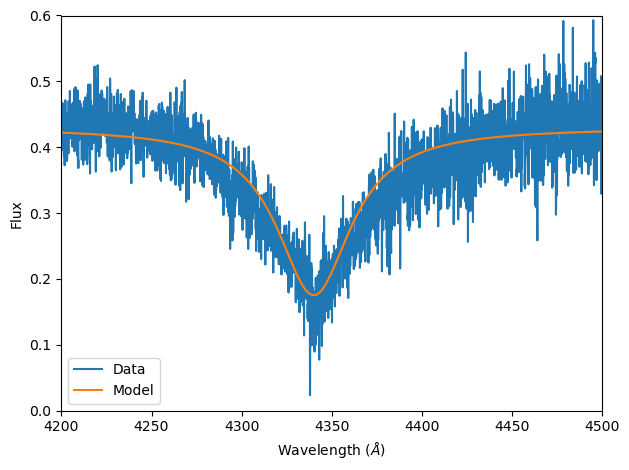

In [4]:
from scipy.stats import cauchy

# Select data within a wavelength range around a particular line
idx = np.intersect1d(np.where(spec['wavelength']>4200)[0], 
                     np.where(spec['wavelength']<4500)[0])
data_x = spec['wavelength'][idx]
data_y = spec['flux'][idx]

# Plot the data
plt.plot(data_x, data_y, label='Data')


# Set the model parameters
coeff = -20.0  # Magnifies the feature
bias = 0.43  # Shifts the spectrum up or down
center_x = 4340  # Shifts the spectrum left or right
scale = 25.0  # Sets the strength of the line


# Calculate the model fluxes
y = coeff*cauchy.pdf(data_x, loc=center_x, scale=scale) + bias

# Plot the model output
plt.plot(data_x, y, label='Model')


# Make the plot pretty
plt.xlim(4200, 4500)
plt.ylim(0, 0.6)

plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux')

plt.legend()

plt.tight_layout()
plt.show()

### Now, let's use an optimization algorithm

We will use `scipy`'s `optimize` library to find the best fit values for those four parameters. First we need to define our chi-square function to minize. Write that in the code block below.

In [5]:
def chi_square(p, data_x, data_y):
    """ Function to calculate the chi-squared value
    
    Parameters
    ----------
    p : tuple
        Set of model parameters
    data_x : numpy array
        Set of wavelengths for the spectrum (angstroms)
    data_y : numpy array
        Set of fluxes for the spectrum
        
    Returns
    -------
    chi_square : float
        Chi-squared value comparing the model to data
    """
    
    # Import the tuple of model parameters
    coeff, bias, center_x, scale = p
    
    # Calculate the model fluxes
    model_y = coeff*cauchy.pdf(data_x, loc=center_x, scale=scale) + bias
    
    # Calculate chi_square by comparing the model fluxes with the observed fluxes
    chi_square = np.sum((data_y - model_y)**2)
    
    return chi_square

### Now, let's minimize!!

To run a minimization algorithm, we need to provide the minimizer with a starting position in our four-dimensional parameter space. We can just use the values you found in the previous exercise.

4342.324510127144 37.90272749689836


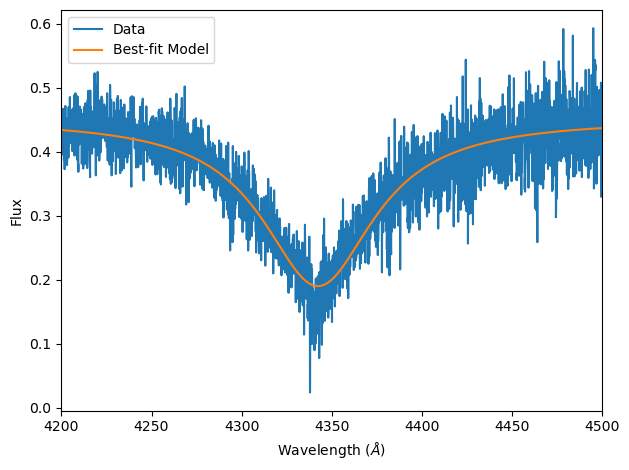

In [6]:
from scipy.optimize import minimize


# Choose the input values previously found
coeff = -20.0
bias = 0.43
center_x = 4340
scale = 25.0


# Store the input values into a tuple
x0 = coeff, bias, center_x, scale

# Run the minimizer
sol = minimize(chi_square, x0, args=(data_x, data_y))

# Calculate the model fluxes from the results of the minimizer
coeff_best, bias_best, center_x_best, scale_best = sol.x
y_best = coeff_best*cauchy.pdf(data_x, loc=center_x_best, scale=scale_best) + bias_best

# Print the central wavelength and scale of the best-fit
print(center_x_best, scale_best)

# Plot the data
plt.plot(data_x, data_y, label='Data')

# Plot the model
plt.plot(data_x, y_best, label='Best-fit Model')

plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux')

plt.xlim(4200, 4500)

plt.legend()

plt.tight_layout()
plt.show()

### Now, try to fit the other Balmer lines. How many can different Balmer lines can you reasonably fit?


For reference, the central wavelengths are provided below:

Hβ = 4861.36 Å  
Hγ = 4340.46 Å  
Hδ = 4101.74 Å  
Hε = 3970.07 Å  
Hζ = 3889.05 Å  
Hη = 3835.38 Å   

4862.554514913053 40.76161748713532
4342.156476517883 35.519713044756045
4102.780818647418 14.831075336136387
3970.1201330672648 11.306532263121268
3888.9776517380656 9.743813184407044


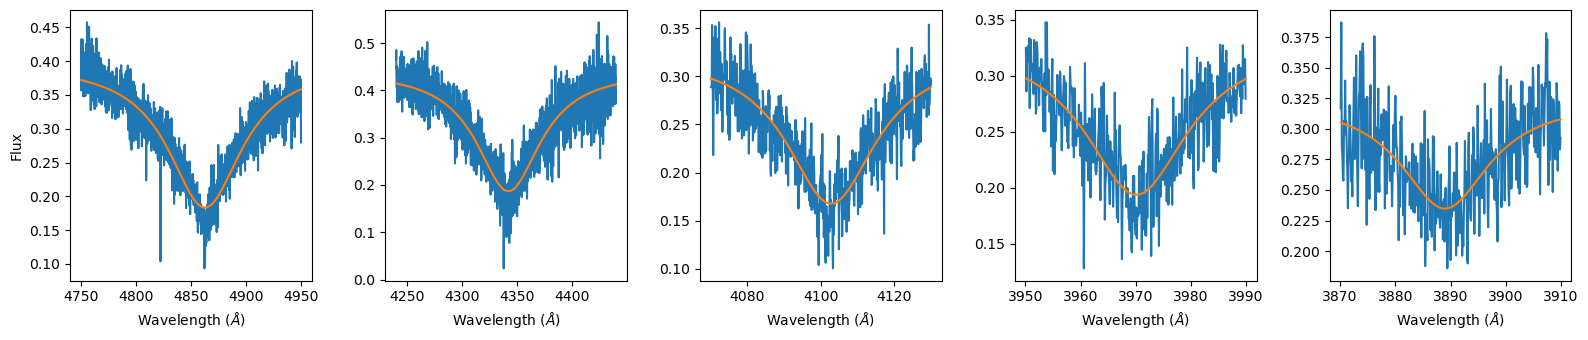

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(16,3.5))



# H_beta
coeff = -20.0
bias = 0.43
center_x = 4850
scale = 25.0

idx = np.where(np.abs(spec['wavelength'] - 4850) < 100.0)[0]

data_x = spec['wavelength'][idx]
data_y = spec['flux'][idx]

x0 = coeff, bias, center_x, scale
sol = minimize(chi_square, x0, args=(data_x, data_y))

ax[0].plot(data_x, data_y, label='Data')

coeff_best, bias_best, center_x_best, scale_best = sol.x
y_best = coeff_best*cauchy.pdf(data_x, loc=center_x_best, scale=scale_best) + bias_best
ax[0].plot(data_x, y_best, label='Best-fit Model')

print(center_x_best, scale_best)




# H_gamma
coeff = -20.0
bias = 0.43
center_x = 4340
scale = 25.0

idx = np.where(np.abs(spec['wavelength'] - 4340) < 100.0)[0]

data_x = spec['wavelength'][idx]
data_y = spec['flux'][idx]

x0 = coeff, bias, center_x, scale
sol = minimize(chi_square, x0, args=(data_x, data_y))

ax[1].plot(data_x, data_y, label='Data')

coeff_best, bias_best, center_x_best, scale_best = sol.x
y_best = coeff_best*cauchy.pdf(data_x, loc=center_x_best, scale=scale_best) + bias_best
ax[1].plot(data_x, y_best, label='Best-fit Model')

print(center_x_best, scale_best)



# H_delta
coeff = -20.0
bias = 0.43
center_x = 4100
scale = 25.0

idx = np.where(np.abs(spec['wavelength'] - 4100) < 30.0)[0]

data_x = spec['wavelength'][idx]
data_y = spec['flux'][idx]

x0 = coeff, bias, center_x, scale
sol = minimize(chi_square, x0, args=(data_x, data_y))

ax[2].plot(data_x, data_y, label='Data')

coeff_best, bias_best, center_x_best, scale_best = sol.x
y_best = coeff_best*cauchy.pdf(data_x, loc=center_x_best, scale=scale_best) + bias_best
ax[2].plot(data_x, y_best, label='Best-fit Model')

print(center_x_best, scale_best)




# H_epsilon
coeff = -20.0
bias = 0.43
center_x = 3970
scale = 25.0

idx = np.where(np.abs(spec['wavelength'] - 3970) < 20.0)[0]

data_x = spec['wavelength'][idx]
data_y = spec['flux'][idx]

x0 = coeff, bias, center_x, scale
sol = minimize(chi_square, x0, args=(data_x, data_y))

ax[3].plot(data_x, data_y, label='Data')

coeff_best, bias_best, center_x_best, scale_best = sol.x
y_best = coeff_best*cauchy.pdf(data_x, loc=center_x_best, scale=scale_best) + bias_best
ax[3].plot(data_x, y_best, label='Best-fit Model')

print(center_x_best, scale_best)







# H_zeta
coeff = -20.0
bias = 0.43
center_x = 3890
scale = 25.0

idx = np.where(np.abs(spec['wavelength'] - 3890) < 20.0)[0]

data_x = spec['wavelength'][idx]
data_y = spec['flux'][idx]

x0 = coeff, bias, center_x, scale
sol = minimize(chi_square, x0, args=(data_x, data_y))

ax[4].plot(data_x, data_y, label='Data')

coeff_best, bias_best, center_x_best, scale_best = sol.x
y_best = coeff_best*cauchy.pdf(data_x, loc=center_x_best, scale=scale_best) + bias_best
ax[4].plot(data_x, y_best, label='Best-fit Model')

print(center_x_best, scale_best)






for a in ax: 
    a.set_xlabel(r'Wavelength ($\AA$)')

ax[0].set_ylabel('Flux')


plt.tight_layout()
plt.show()

### Questions for discussion

1. How many lines were you able to fit?  
2. What are the best-fit values of the scale parameters?  
3. What are the redshifts in wavelength you find for the separate lines?  
4. How do those values change depending on the range of data used for each line?  


### Conclusions

Non-linear effects in the atmospheres of white dwarfs prevent us from being able to directly translate the scales and depths of these lines into meaningful physical parameters like temperature and surface gravity. Neverthless, this ought to serve as a guide for how one can use the routine `scipy.optimize.minimize` for fitting models to data.

We will spend more time fitting models to data in future lessons.